# Enhanced 2 Step Floating Catchment Area 

The goal of this notebook is to present the process of producing the E2SFCA accessibility score. The original code can be found in the "scripts" folder of the GitHub repository, under the name "e2sfca.py"

##### Import libraries, functions and data

In [1]:
# Import libraries and functions
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import fiona
from collections import defaultdict
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point #  to create buffers (check the intersections in get_accessibility_dict)
import sys

# I will employ some functions that I defined in accessibility_functions module
acc_functions_path = os.path.abspath(os.path.join("..", "scripts"))
if acc_functions_path not in sys.path:
    sys.path.append(acc_functions_path)

from accessibility_functions import (
    get_accessibility_dict,
    get_ugs_to_pop_ratios,
    plot_census_points_with_basemap,
    get_census_served,
    get_people_served,
    get_census_catchment,
    get_accessibility_index,
    plot_parks_by_ratio,
    plot_parks_ratio_people
)

In [2]:
# Import data
data = os.path.join("..\\data\\final\\Tokyo_UGS_accessibility.gpkg")
study_area_boundary = gpd.read_file(data, layer='tokyo_boundary') # necessary only for plots
accesses = gpd.read_file(data, layer="park_accesses") # gdf of all park access points
ugs = gpd.read_file(data, layer='ugs') # gdf of parks polygons
parks330 = gpd.read_file(data, layer="sa_parks330") # service area for each park access point (330m)
parks660 = gpd.read_file(data, layer="sa_parks660") # service area for each park access point (660m)
parks1000 = gpd.read_file(data, layer="sa_parks1000") # service area for each park access point (1000m)

# filter parks with area below 30sqm: these are mistakes resulting from the merging process.
parks330 = parks330.query("area >= 30")
parks660 = parks660.query("area >= 30")
parks1000 = parks1000.query("area >= 30")

# Census catchement areas 
all_census = gpd.read_file(data, layer='all_census_units') # needed for ugs ratios (1st step)
census = gpd.read_file(data, layer='internal_census_units') # relevant census units for 2nd step
census330 = gpd.read_file(data, layer="int_census330") # catchment area for census units (330m)
census660 = gpd.read_file(data, layer="int_census660") # catchment area for census units (660m)
census1000 = gpd.read_file(data, layer="int_census1000") # catchment area for census units (1000m)

Brief visualization of the population in each census unit
- Visualize the distribution of the population
- Visualize the 1st perenctile of census units by population

In [3]:
print("Descripive statistics of the population of all census units:")
print(all_census["pop_tot"].describe())
print("\n Descriptive statistics of the population of 'internal' census units")
print(census["pop_tot"].describe())

Descripive statistics of the population of all census units:
count    8527.000000
mean     1155.265861
std       592.951411
min         1.000000
25%       775.500000
50%      1130.000000
75%      1508.500000
max      7373.000000
Name: pop_tot, dtype: float64

 Descriptive statistics of the population of 'internal' census units
count    7136.000000
mean     1220.459922
std       593.137282
min         1.000000
25%       861.000000
50%      1201.000000
75%      1565.000000
max      7373.000000
Name: pop_tot, dtype: float64


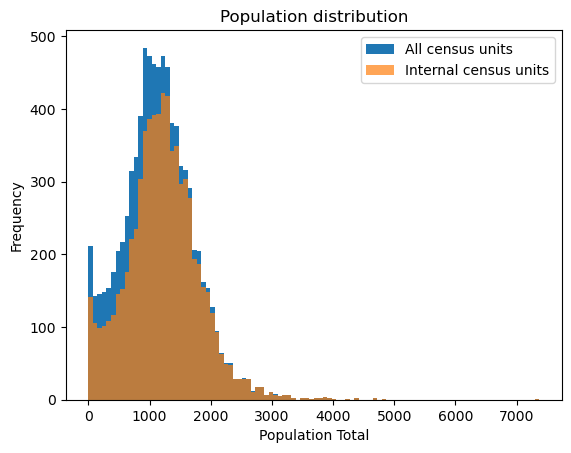

In [4]:
plt.hist(all_census["pop_tot"], bins=100, label='All census units')
plt.hist(census["pop_tot"], bins=100, alpha=0.7, label='Internal census units')
plt.xlabel('Population Total')
plt.ylabel('Frequency')
plt.legend()
plt.title('Population distribution')
plt.show()

I defined the function `plot_census_points_with_basemap` to visualize potentially problematic census units.
<br>
The function takes three arguments:
- geodataframe with census centroids
- string *under* or *over*, depending on the relevant filter
- a threshold value to filter the census centroids

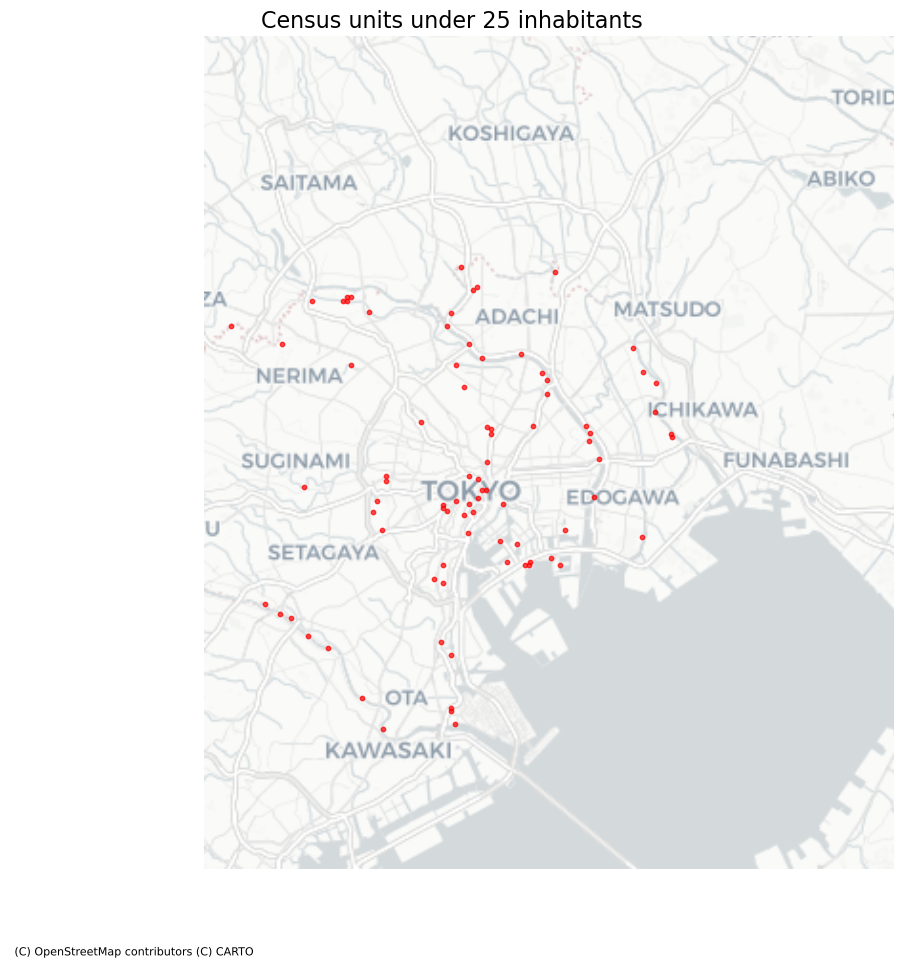

In [5]:
plot_census_points_with_basemap(all_census, "under", all_census.pop_tot.quantile(0.01))

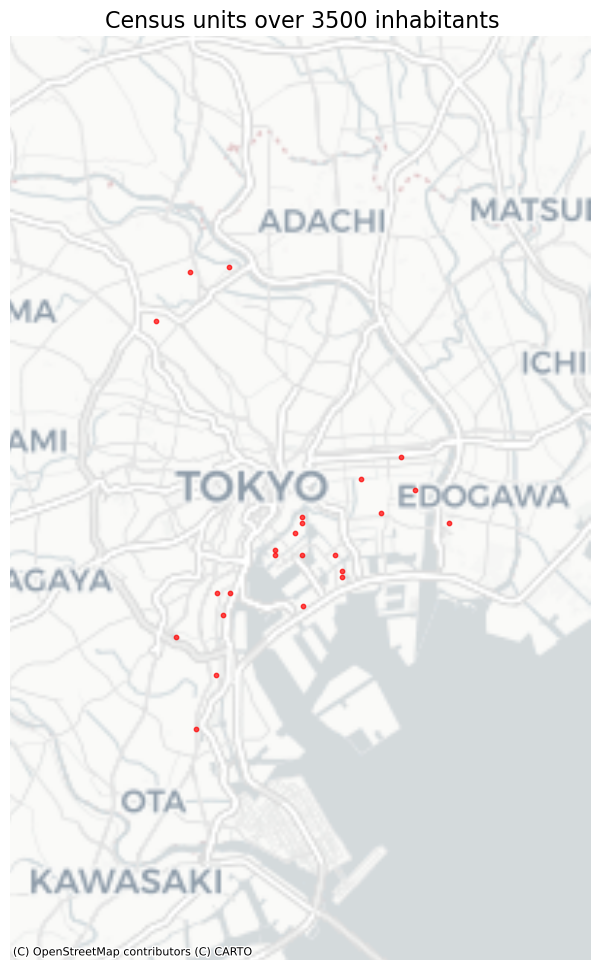

In [6]:
plot_census_points_with_basemap(all_census, "over", 3500)

##### E2SFCA Step 1

In the 1st step of the E2SFCA the UGS to population ratios are obtained. <br>
These ratio represent the contribution of each park to the accessibility index of the census unit. The ratios $R_j$ are computed according to the following formula:

$R_j$:  
$$
R_j = \frac{S_j}{\sum\limits_{d_{kj} \in D_1} P_k W_1 + \sum\limits_{d_{kj} \in D_2} P_k W_2 + \sum\limits_{d_{kj} \in D_3} P_k W_3}
$$

Where :
- $P_k$ is the population of census point $k$ within the catchment $j$. 
- $S_j$ is the area of the greenspace $j$. 
- $d_{kj}$ is the distance between *k* and *j*. 
- $D$ represents the travel time zone (1 is within 330m, 2 between 331m and 660m and 3 between 661m and 1000m). 
- $W_r$ represents the weight of each travel time zone. 

The function `full_accessibility_dict` returns a nested dictionary that links to each park ID the park area and three lists. Each list represent a travel distance zone, and it contains the census units that are intersected in that specific zone. Each census unit is unique across the three lists, giving priority to the shortes travel zone (i.e., 330m > 660m > 1000m)

In [7]:
full_accessibility_dict = get_accessibility_dict(  # defined in accessibility_functions.py
    accesses, parks330, parks660, parks1000, all_census # all_census to solve issue of boundary parks
)
# get for each park its supply over population ratio (UGS to population ratio)
ugs_to_pop_ratios = get_ugs_to_pop_ratios(full_accessibility_dict, all_census)  # same as above

Inspect the UGS to population ratios:

In [8]:
print("Distribution of UGS to population ratios:\n")
print(pd.Series(list(ugs_to_pop_ratios.values())).describe())

Distribution of UGS to population ratios:

count     8241.000000
mean        19.217037
std        595.215442
min          0.000000
25%          0.032944
50%          0.076503
75%          0.220849
max      36757.000000
dtype: float64


The distribution is problematic: the median is 0.07, while the maximum is 36757 <br>
UGS to population ratios are affected by two variables: 
- people living within 1000m of the park
- park area

The distribution is probably affected by parks with few people living in their surroundings. <br>
Let's look deeper into the amount of people served by the parks with the highest ratios:

In [9]:
top_parks = sorted(ugs_to_pop_ratios.items(), key=lambda x: x[1], reverse=True)
top_parks = [t[0] for t in top_parks[:20]]
all_parks = list(ugs_to_pop_ratios.keys())

# UGS to population ratios have issues due to low population census units
# I can either trim the census units or the problematic parks
# Eliminating census units does not necessarily fixed the problem
# I decide to eliminate the parks below the 1st percentile of "affluence" (sum of people living within 1km)
census_for_top_parks = get_census_served(top_parks, full_accessibility_dict)
people_for_top_parks = get_people_served(top_parks, full_accessibility_dict, all_census) 
people_for_all_parks = get_people_served(all_parks, full_accessibility_dict, all_census)

Summary statistics of people living within 1km of all parks: 
 count     8241.000000
mean     34342.079238
std      12618.224802
min          8.000000
25%      26102.000000
50%      34187.000000
75%      42659.000000
max      96628.000000
dtype: float64

First percentile of people living within a park's catchement area: 2866.4
Summary statistics of people living within 1km of top 20 parks by ratio: 
 count      20.000000
mean      279.150000
std       463.257945
min         8.000000
25%        37.000000
50%       111.000000
75%       170.000000
max      1657.000000
dtype: float64


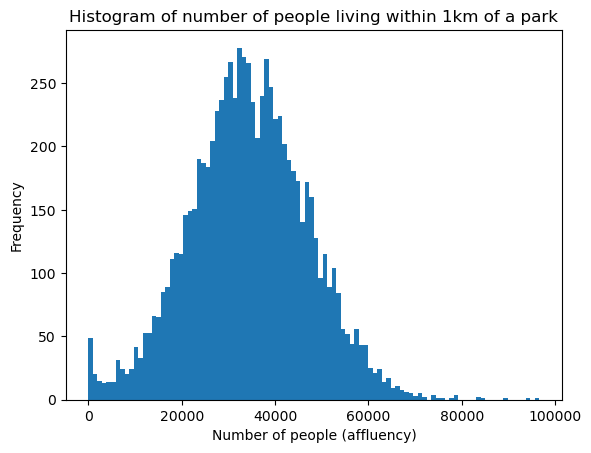

In [10]:
pap_description = pd.Series(list(people_for_all_parks.values())).describe()
print(f"Summary statistics of people living within 1km of all parks: \n {pap_description}")
pd.Series(list(people_for_all_parks.values())).plot(kind='hist',bins=100, 
                                                    title='Histogram of number of people living within 1km of a park',
                                                    xlabel='Number of people (affluency)')

ppl_1percentile = pd.Series(list(people_for_all_parks.values())).quantile(0.01) # 2866
print(f"\nFirst percentile of people living within a park's catchement area: {ppl_1percentile}")

ptp_description = pd.Series(list(people_for_top_parks.values())).describe() # all values are now below the 1st percentile value population wise
print(f"Summary statistics of people living within 1km of top 20 parks by ratio: \n {ptp_description}")

Let's define as `affluence` the number of people living within 1000m of a given park. <br>
I add the `affluence` and `ugs_to_pop_ratios` values to the `ugs` geodataframe. Then, I filter out the parks that 'serve' less than 2866 people (the first percentile of the number of people living within 1km of a park)

In [11]:
# final substep: add UGS_to_pop ratio to "accesses" geodataframe
accesses["ugs_ratio"] = accesses["park_id"].map(ugs_to_pop_ratios)

# check where the parks with highest ratio are
parks = ugs[ugs['park_id'].isin(accesses['park_id'])] 
parks = parks.copy()
parks.loc[:,'ugs_ratio'] = parks['park_id'].map(ugs_to_pop_ratios) # map the ratios
# I add the number of people that can access each park
parks.loc[:, 'affluency'] = parks['park_id'].map(people_for_all_parks)

relevant_parks = dict(filter(lambda x: x[1] > ppl_1percentile, people_for_all_parks.items())) # switch 713 with ppl_1percentile
relevant_parks = list(relevant_parks.keys())
accesses = accesses[accesses['park_id'].isin(relevant_parks)] # filter out parks without people | from 17831 to 16000
parks = parks[parks['park_id'].isin(relevant_parks)] # filter out the parks with low affluence 

Let's investigate further the distribution of *people for each park* and the *UGS to population ratio*.

In [12]:
print(f"Distribution of UGS to population ratios \n{parks['ugs_ratio'].describe()}")

print(f"\nDistribution of affluence for each park \n{parks.affluency.describe()}")

n_parkslowratio = parks[parks['ugs_ratio']<1.5]['park_id'].nunique() # 7752 parks out of 8158 have ratio below 1.5
n_parkshighratio = parks[parks['ugs_ratio']>1.5]['park_id'].nunique() # 406

print(f"\nThere are {n_parkshighratio} parks with ratio above 1.5")
print(f"\nThere are {n_parkslowratio} parks with ratio below 1.5")


Distribution of UGS to population ratios 
count    8158.000000
mean        0.832574
std         9.238358
min         0.002150
25%         0.032673
50%         0.075577
75%         0.212308
max       457.240550
Name: ugs_ratio, dtype: float64

Distribution of affluence for each park 
count     8158.000000
mean     34682.108973
std      12220.946353
min       2885.000000
25%      26428.250000
50%      34326.500000
75%      42729.750000
max      96628.000000
Name: affluency, dtype: float64

There are 406 parks with ratio above 1.5

There are 7752 parks with ratio below 1.5


Plot of all UGS to population ratios


<Axes: title={'center': 'Plot of all UGS to population ratios'}, xlabel='UGS to population ratio', ylabel='Frequency'>

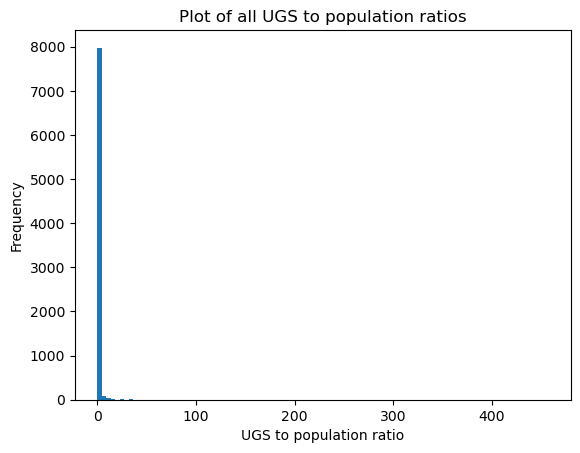

In [13]:
print("Plot of all UGS to population ratios")
parks['ugs_ratio'].plot(kind='hist', 
                        bins=100, 
                        title='Plot of all UGS to population ratios',
                        xlabel='UGS to population ratio')

<Axes: title={'center': 'Plot of UGS to population ratios below 1.5'}, xlabel='UGS to population ratio', ylabel='Frequency'>

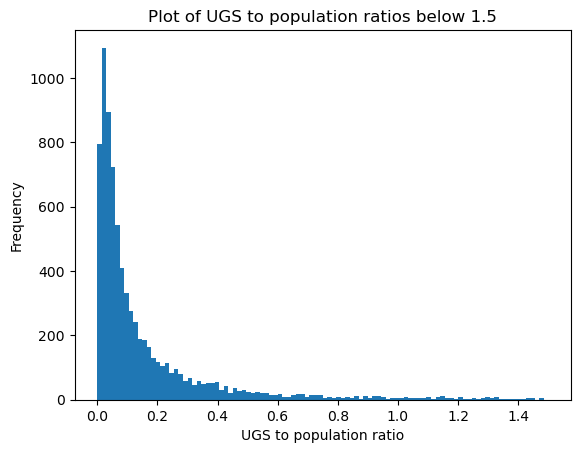

In [14]:
parks['ugs_ratio'].plot(kind='hist', 
                        bins=100, 
                        title="Plot of UGS to population ratios below 1.5",
                        xlabel='UGS to population ratio',
                        range=(0,1.5))

##### Park categories (by size)
Let's visualize different plots of the park areas

<Axes: title={'center': 'Histogram of park areas, bins = 100'}, ylabel='Frequency'>

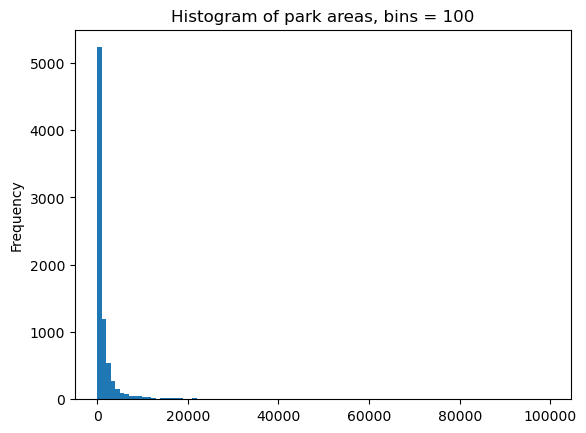

In [15]:
parks[parks['area']<100000]['area'].plot(kind='hist',bins=100, title='Histogram of park areas, bins = 100') 


<Axes: title={'center': 'Histogram of park areas, bins = 100'}, ylabel='Frequency'>

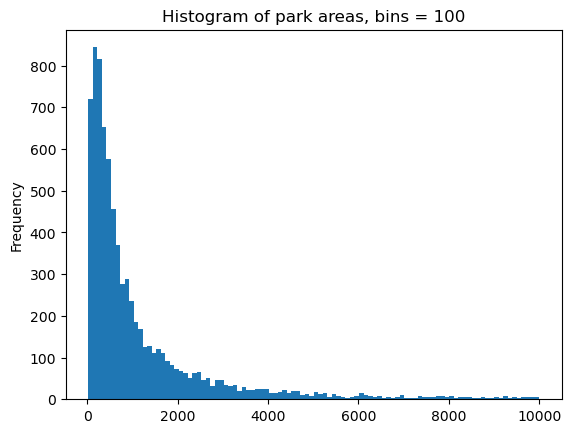

In [16]:
parks[parks['area']<10000]['area'].plot(kind='hist',bins=100, title='Histogram of park areas, bins = 100')


<Axes: title={'center': 'Histogram of park areas, bins = 100'}, ylabel='Frequency'>

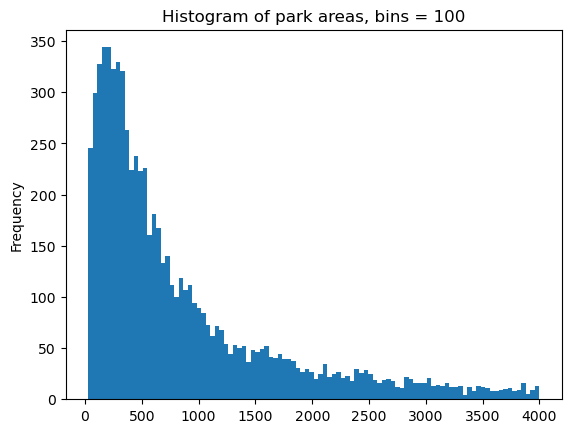

In [17]:
parks[parks['area']<4000]['area'].plot(kind='hist',bins=100, title='Histogram of park areas, bins = 100')

Many positive outliers 'contaminate' the distribution. Thus, I divide park categories by using the logarithmic transformation of the `park_area` variable.

In [18]:
parks.loc[:, 'log_area'] = np.log10(parks['area']) # log transform park areas

# Define boundaries and labels for coloring
labels = ["Very Small", "Small", "Medium", "Large", "Very Large"]
colors = ["#FF9999", "#FFCC99", "#99FF99", "#66CCFF", "#CC99FF"]
size_colors = dict(zip(labels, colors))

# create categorical variable for park size
quantiles_parks = parks['log_area'].quantile([0, 0.25, 0.5, 0.75, 0.95, 1]) # last 5% is to capture the big parks (above 10k)
parks = parks.copy()
parks.loc[:, "size_cat"] = pd.cut(parks["log_area"], bins=quantiles_parks, labels=labels, include_lowest=True)

print(parks["size_cat"].value_counts()) # check for safety

# add size category to the accesses gdf
accesses.loc[:, 'size_cat'] = accesses['park_id'].map(parks.set_index('park_id')['size_cat'])

vl_accesses = accesses[accesses['size_cat']=="Very Large"]
lg_accesses = accesses[(accesses['size_cat']== "Very Large") | (accesses['size_cat']=="Large")]
md_accesses = accesses[(accesses['size_cat']== "Very Large") | 
                       (accesses['size_cat']=="Large") |
                       (accesses['size_cat']=="Medium")]
sm_accesses = accesses[(accesses['size_cat']== "Very Large") | 
                       (accesses['size_cat']=="Large") |
                       (accesses['size_cat']=="Medium") |
                       (accesses['size_cat']=="Small")]
all_accesses = accesses.copy()



size_cat
Very Small    2040
Small         2039
Medium        2039
Large         1632
Very Large     408
Name: count, dtype: int64


Visualizations of the division in size categories

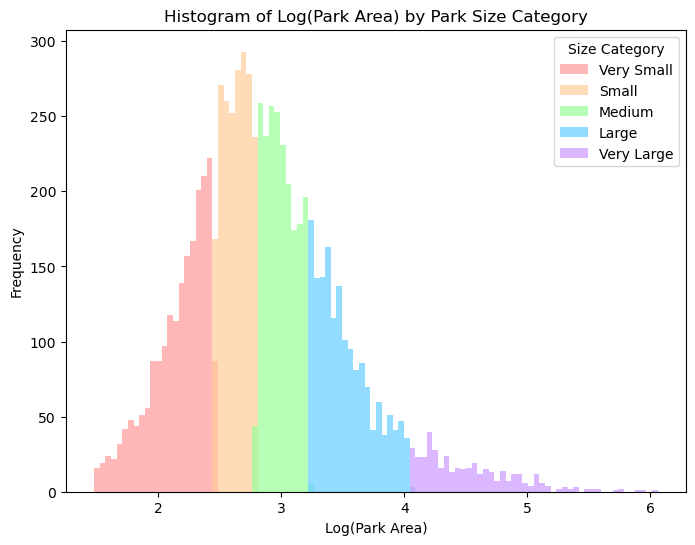

In [19]:
## Histogram log(area) by park size category ##
plt.figure(figsize=(8, 6))  # Start a new figure

# loop through each category and plot it on the same axis (otherwise height mismatch)
for category, color in size_colors.items():
    # Filter data for each category
    data_plot = parks[parks['size_cat'] == category]['log_area']
    
    plt.hist( # plot filtered data
        data_plot, 
        bins=100, 
        color=color, 
        alpha=0.7,  # Transparency for better overlap visibility
        label=category,
        range=(parks['log_area'].min(), parks['log_area'].max())  # full data range
    )

plt.xlabel("Log(Park Area)")
plt.ylabel("Frequency")
plt.title("Histogram of Log(Park Area) by Park Size Category")
plt.legend(title="Size Category")
plt.show()  # Display the plot

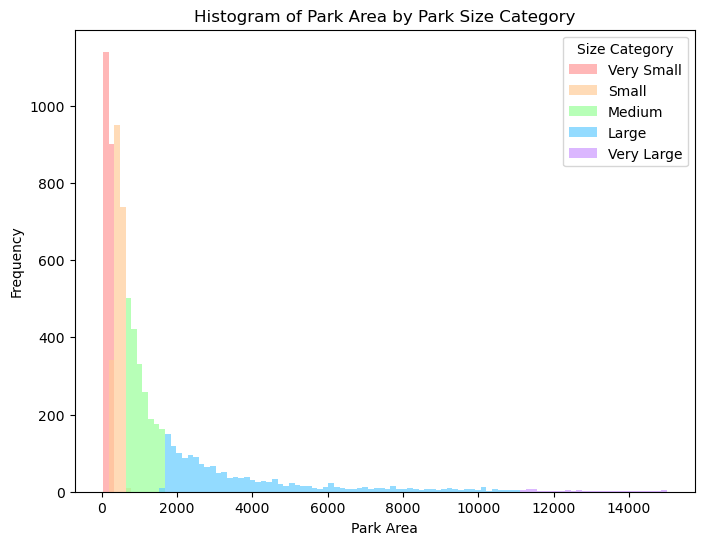

In [20]:
# Histogram 'area' by park size category #####################################################
plt.figure(figsize=(8, 6))  # Start a new figure

for category, color in size_colors.items():
    data_plot = parks[parks['size_cat'] == category]['area']
    
    plt.hist(
        data_plot, 
        bins=100,  
        color=color, 
        alpha=0.7,  
        label=category,
        range=(parks['area'].min(), 15000)  # full range is problematic
    )

plt.xlabel("Park Area")
plt.ylabel("Frequency")
plt.title("Histogram of Park Area by Park Size Category")
plt.legend(title="Size Category")
plt.show()

The following graphs plot the distribution of multiple variables. The value of `ratio_limit` can be adjusted to include outliers in the graphs. Default value is 2.

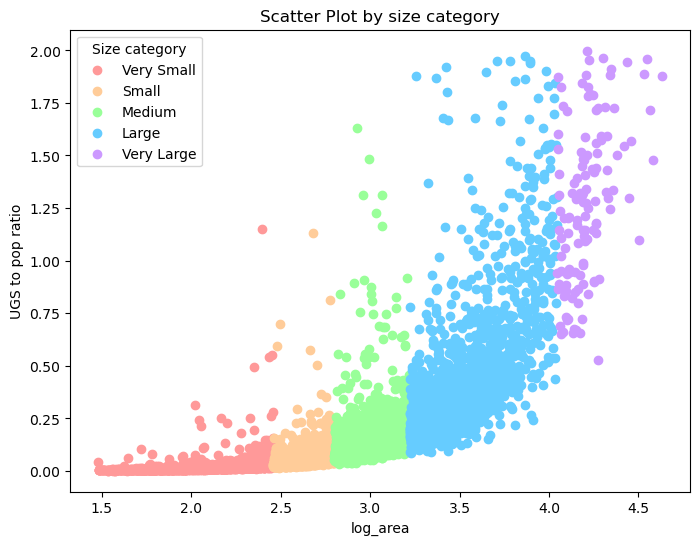

In [21]:
ratio_limit = 2 # set as you wish for visualization purposes (the following plots)
parks_no_out = parks[parks['ugs_ratio']<ratio_limit] # remove outliers

plt.figure(figsize=(8, 6))
for category, color in size_colors.items():
    subset = parks_no_out[parks_no_out['size_cat'] == category]
    plt.scatter(subset['log_area'], subset['ugs_ratio'], label=category, color=color)

plt.xlabel('log_area')
plt.ylabel('UGS to pop ratio')
plt.title('Scatter Plot by size category')
plt.legend(title='Size category')
plt.show()

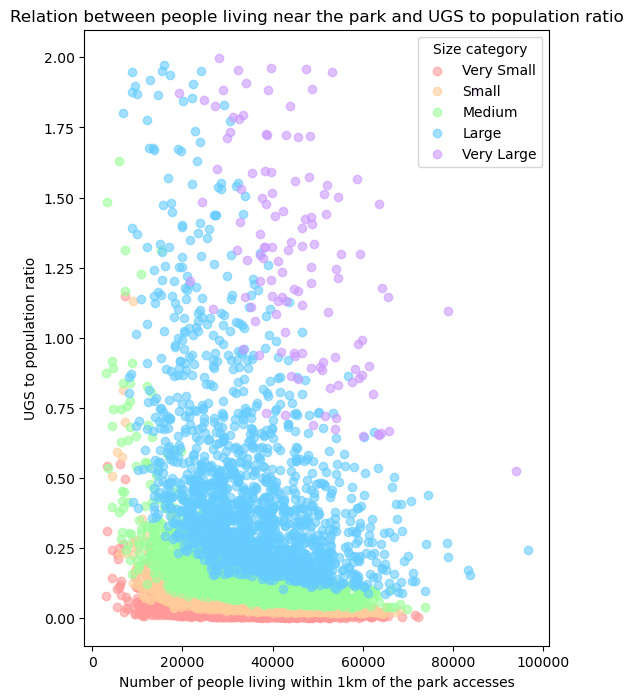

In [22]:
# plot relationship between 'affluence' and ugs to population ratio 
plt.figure(figsize=(6,8))
for category, color in size_colors.items():
    subset = parks_no_out[parks_no_out['size_cat']==category]
    plt.scatter(subset['affluency'],subset['ugs_ratio'], label=category, color=color, alpha=0.6)

plt.xlabel('Number of people living within 1km of the park accesses')
plt.ylabel("UGS to population ratio")
plt.title("Relation between people living near the park and UGS to population ratio")
plt.legend(title='Size category')
plt.show()


While the first step of the E2SFCA was successfully performed, there are some positive outliers that must be taken care of. I will use two functions to inspect them.
- `plot_parks_by_ratio`: the middle argument is the ratio threshold above which the parks are shown. The color represents the UGS to population ratio.
- `plot_parks_ratio_people`: works like the previous function, but the color represent the number of people living within 1km of the park. By using both visualizations it can be evaluated whether a certain park's ratio is problematic due to the (low) number of people living nearby or for other reasons. 

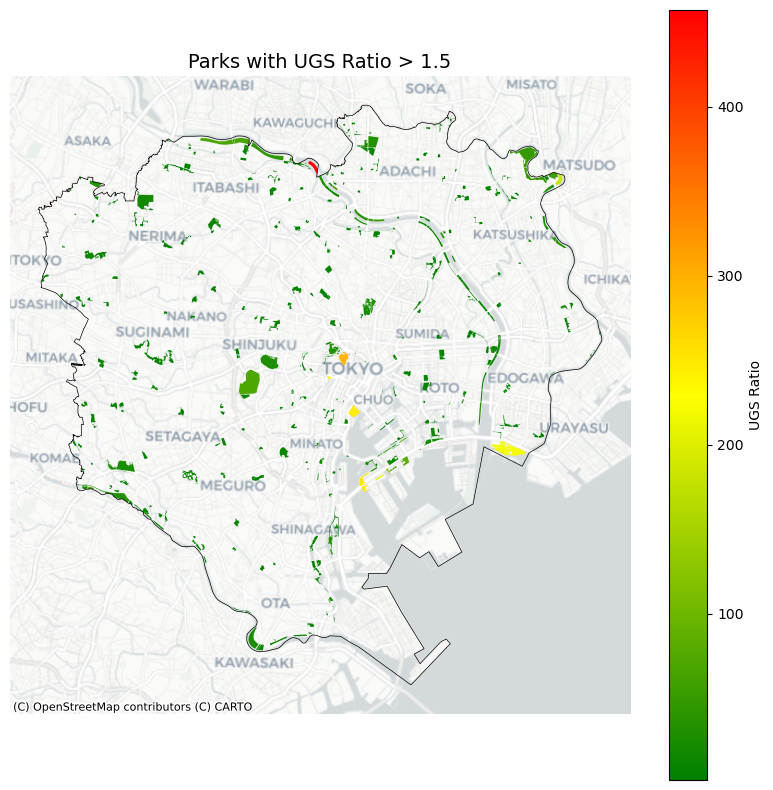

In [23]:
plot_parks_by_ratio(parks, 1.5, study_area_boundary) 

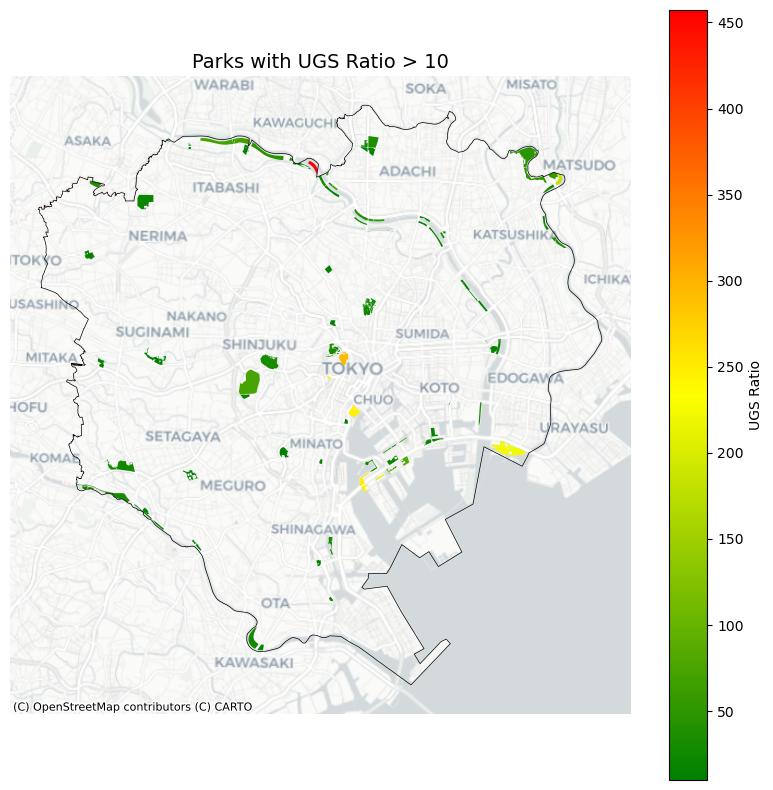

In [24]:
plot_parks_by_ratio(parks, 10, study_area_boundary)

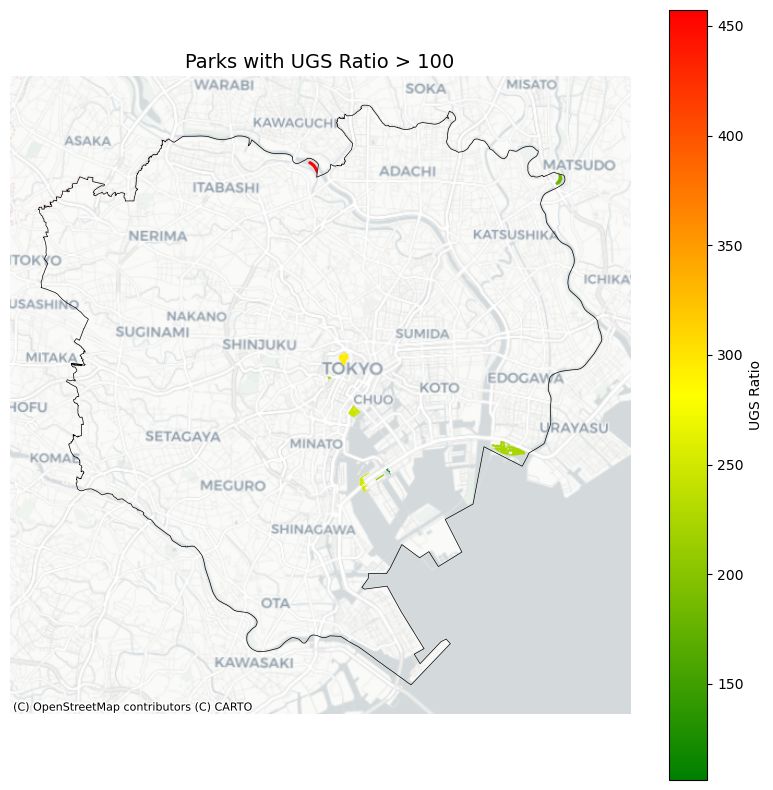

In [25]:
plot_parks_by_ratio(parks, 100, study_area_boundary) 

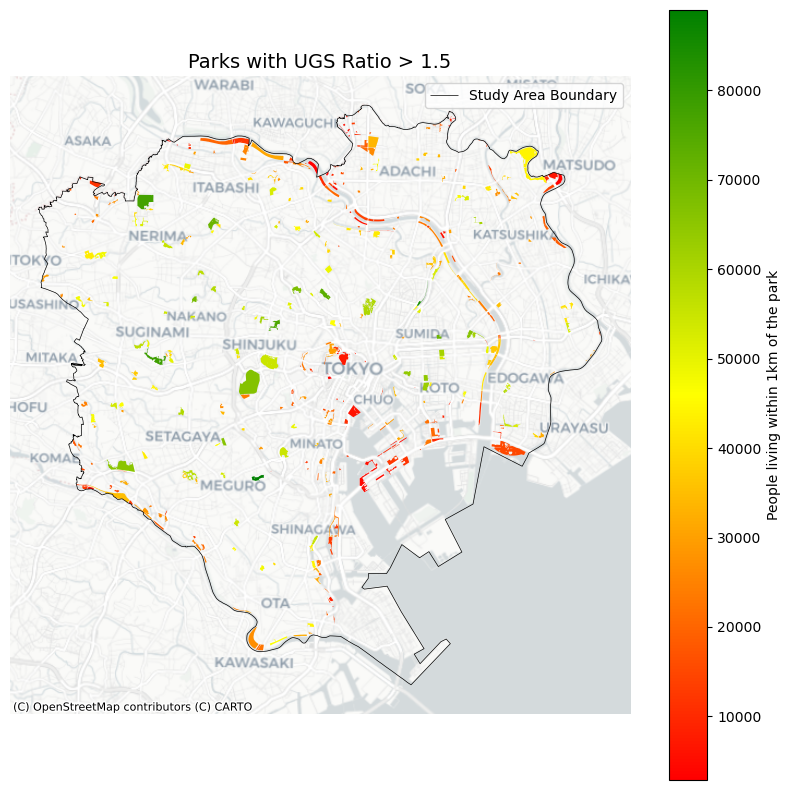

In [26]:
plot_parks_ratio_people(parks, 1.5, study_area_boundary)

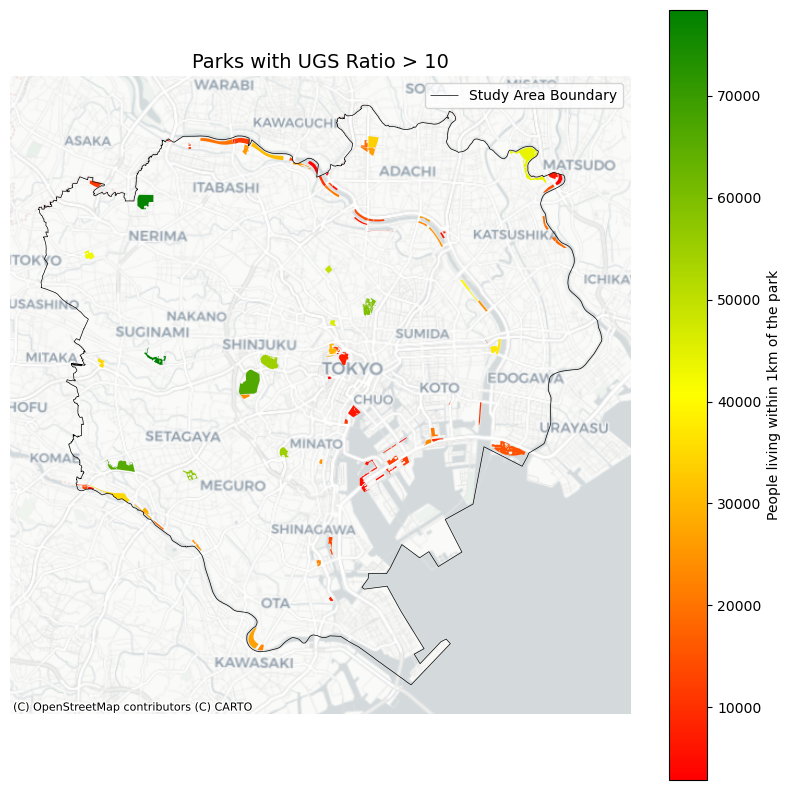

In [27]:
plot_parks_ratio_people(parks, 10, study_area_boundary)

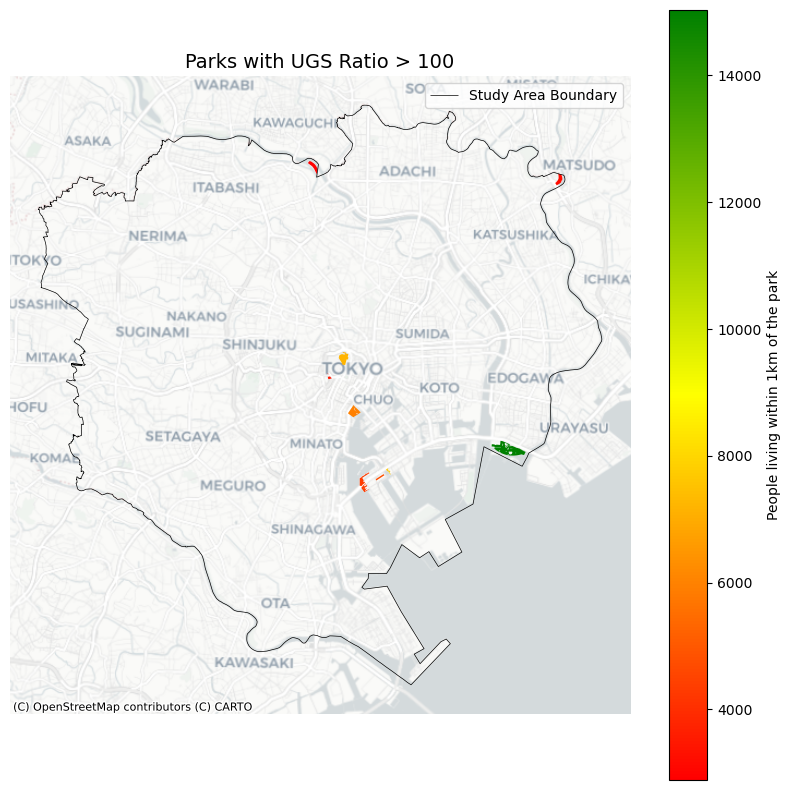

In [28]:
plot_parks_ratio_people(parks, 100, study_area_boundary)

There are two categories of "problematic" parks: 
1. Large parks in non residential areas (Chiyoda/Koto city)
2. Riversides -> large and few people in the surrounding. Adding other variables to park supply would lower their ratios (facilities, length of trails inside parks)
3. Parks at the edges of Tokyo (because I do not consider the census unit outside the study area in the UGS_ratio computation)

##### E2SFCA Step 2

The second step of the E2SFCA process is based on the census units. <br>
For each census unit, three travel distances are defined (as in the first step). For each travel distance zone, all the accessible parks are identified. The sum of all the accessible parks' ratios is computed. The sum is then weighted by the associated weight. The contribution of the travel time zones are summed.
More formally: <br>

$$A_j^F = \sum\limits_{j\in(d_{ij}) \in D_1} R_jW_1 + \sum\limits_{j\in(d_{ij}) \in D_2} R_jW_2 + \sum\limits_{j\in(d_{ij}) \in D_3} R_jW_3 $$

Where:
- $A_i^F$ represents the accessibility of population of location $i$ to greenspace
- $R_j$ is the UGS to population ratio at for park $j$ (computed in step one) that falls within the catchment of the census unit $i$. 
- $W_r$ represents the weights associated with the distance decay.

In [29]:
vl_census_catchements = get_census_catchment(vl_accesses, census330, census660, census1000, census)  # census are the internal units           
vl_acc_index = get_accessibility_index(vl_census_catchements, census, full_accessibility_dict)

lg_census_catchements = get_census_catchment(lg_accesses, census330, census660, census1000, census)             
lg_acc_index = get_accessibility_index(lg_census_catchements, census, full_accessibility_dict)

md_census_catchements = get_census_catchment(md_accesses, census330, census660, census1000, census)             
md_acc_index = get_accessibility_index(md_census_catchements, census, full_accessibility_dict)

sm_census_catchements = get_census_catchment(sm_accesses, census330, census660, census1000, census)             
sm_acc_index = get_accessibility_index(sm_census_catchements, census, full_accessibility_dict)

all_census_catchements = get_census_catchment(all_accesses, census330, census660, census1000, census)             
all_acc_index = get_accessibility_index(all_census_catchements, census, full_accessibility_dict)


# map the e2sfca index to the census units layer
census["full_ugs_accessibility"] = census["KEY_CODE_3"].map(all_acc_index)
census["vl_ugs_accessibility"] = census["KEY_CODE_3"].map(vl_acc_index)
census["lg_ugs_accessibility"] = census["KEY_CODE_3"].map(lg_acc_index) 
census["md_ugs_accessibility"] = census["KEY_CODE_3"].map(md_acc_index) 
census["sm_ugs_accessibility"] = census["KEY_CODE_3"].map(sm_acc_index)

c:\Users\Luca\miniconda3\envs\spatial\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Luca\miniconda3\envs\spatial\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Luca\miniconda3\envs\spatial\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Evaluate the results of the E2SFCA method for the "very large parks" subset and for the entire dataset

count    5037.000000
mean        5.451877
std        20.799514
min         0.015766
25%         0.205559
50%         1.228052
75%         4.091095
max       536.066608
Name: vl_ugs_accessibility, dtype: float64


<Axes: ylabel='Frequency'>

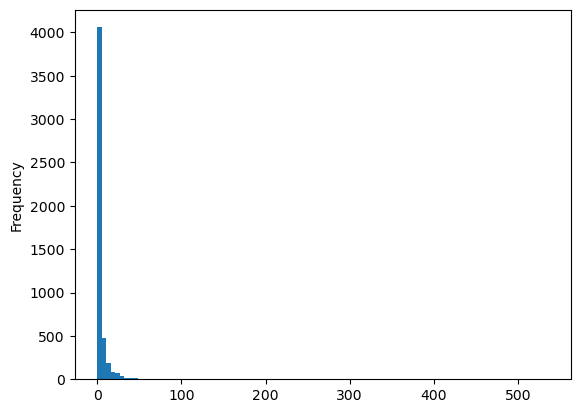

In [30]:
print(census['vl_ugs_accessibility'].describe())
census['vl_ugs_accessibility'].plot(kind='hist',bins=100)

count    7066.000000
mean        5.107219
std        18.885469
min         0.000313
25%         0.786079
50%         1.622216
75%         3.925957
max       539.849321
Name: full_ugs_accessibility, dtype: float64


<Axes: ylabel='Frequency'>

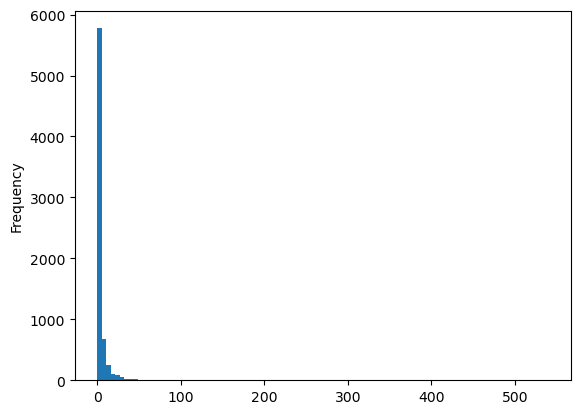

In [31]:
print(census['full_ugs_accessibility'].describe())
census['full_ugs_accessibility'].plot(kind='hist',bins=100)

The accessibility metric are clearly affected by some parks with unusually high UGS to population ratio. Before normalizing these results these problematic parks must be analyzed more in detail